In [1]:
import glob
import os
import datetime
import numpy as np
import pytz
import gpxpy
import shutil
import cmocean
import colorcet
import GPX_functions
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from mpl_toolkits.basemap import Basemap
import logging
import geopandas
from pyproj import Proj, transform
from importlib import reload
reload(GPX_functions)
plt.style.use('dark_background')
plt.rcParams.update({'font.size': 22})

In [2]:
from matplotlib.font_manager import FontProperties
fontfile = "/home/ctroupin/.fonts/D-DIN.ttf"
myfont = FontProperties(fname=fontfile)
mycolor1 = "#fb8500"
mycolor1b = "#ffb703"
mycolor2 = "#219ebc"

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("Starting")

INFO:root:Starting


In [4]:
figdir = "../images/Sleeping/"
if not os.path.exists(figdir):
    os.makedirs(figdir)
datafilelist = sorted(glob.glob(os.path.join("/data/GPX/Moves/gpx/Verviers/", "*.gpx")))
outputdir = "/data/GPX/Sleeping/"
mycolor = "#FF963D"
logger.info("Found {} files".format(len(datafilelist)))

INFO:root:Found 705 files


In [5]:
t0list = []
dlist = []
lonall = np.array([])
latall = np.array([])
eleall = np.array([])
speedall = np.array([])
lonmean = np.array([])
latmean = np.array([])
iii = 0
for datafile in datafilelist:
    lon, lat, ele, t = GPX_functions.read_gpx(datafile)
    try:
        t0 = t[0]
        
        if t0.hour >= 17.:
            
            dist = GPX_functions.compute_dist(lon, lat)
            deltatime = t[1:] - t[0:-1]
            deltatime_s = [dddd.total_seconds() for dddd in deltatime]
            deltatime_s = np.array(deltatime_s)
            
            # Compute speed (in km/h)
            deltatime = t[-1] - t[0]
            meanspeed = dist.sum() / (deltatime.total_seconds() / 3600.)
            
            # Discard tracks longer than 7 km or faster than 6 km/h
            if (dist.sum() < 7.) & (dist.sum() > 0.050) & (meanspeed < 6.):
                iii += 1
                lonall = np.append(lonall, lon)
                latall = np.append(latall, lat)
                eleall = np.append(eleall, ele)
                
                lonmean = np.append(lonmean, lon.mean())
                latmean = np.append(latmean, lat.mean())
                
                speed = dist[1:] / (deltatime_s / 3600.)
                speedall = np.append(speedall, 0.0)
                speedall = np.append(speedall, speed)

                t0list.append(t0)
                dlist.append(dist.sum())
                
                # Copy file to another directory
                shutil.copy2(datafile, outputdir)
                    
    except IndexError:
        logger.warning("No records in file {}".format(datafile))
logger.info(f"{iii} tracks after 6PM")

INFO:root:164 tracks after 6PM


In [6]:
daylist = [(tt  - datetime.datetime(1970,1,1, tzinfo=pytz.utc)).days for tt in t0list]
xticklist = [datetime.datetime(2020, mm, 1) for mm in range(8, 13)]
xticklist2 = [datetime.datetime(2021, mm, 1) for mm in range(1, 5)]
xticklist = [*xticklist, *xticklist2]
xticks = [(tt  - datetime.datetime(1970,1,1)).days for tt in xticklist]

In [7]:
darray = np.array(dlist)
indmax = np.argmax(darray)
distmax = darray[indmax]
datemax = t0list[indmax].strftime("%d %B %Y")
indmin = np.argmin(darray)
distmin = darray[indmin]
datemin = t0list[indmin].strftime("%d %B %Y")
logger.info(f"Longest distance: {distmax} on {datemax}")
logger.info(f"Shortest distance: {distmin} on {datemin}")

logger.info(f"Total distance: {darray.sum()}")
logger.info(f"Number of track: {len(darray)}")
logger.info(f"Number of positions: {len(lonall)}")

INFO:root:Longest distance: 5.129655233766995 on 22 November 2020
INFO:root:Shortest distance: 0.08443562942534662 on 23 January 2021
INFO:root:Total distance: 399.5091729279387
INFO:root:Number of track: 164
INFO:root:Number of positions: 136854


In [8]:
len(lonall)

136854

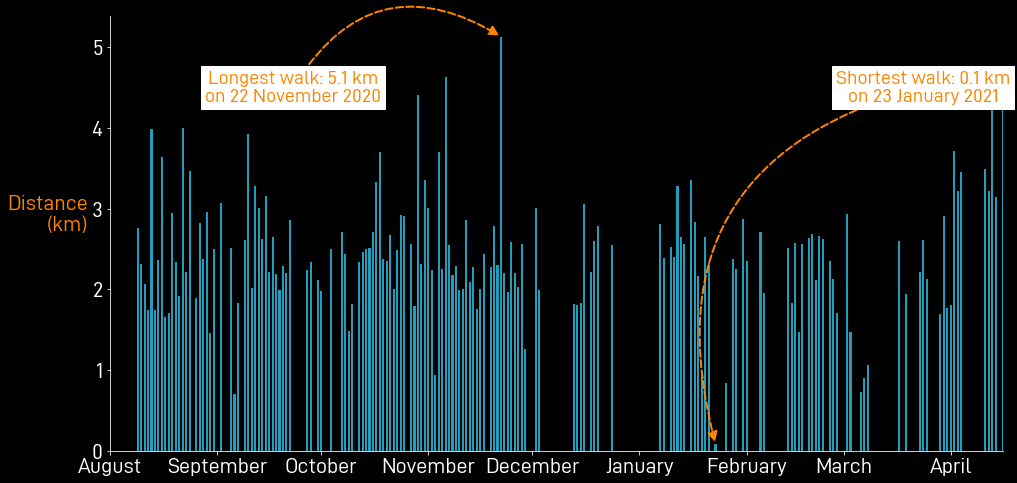

In [9]:
plt.figure(figsize=(16, 8))
ax = plt.subplot(111)
ax.bar(daylist, dlist, width=.6, color=mycolor2, zorder=3)
ax.set_ylabel("Distance\n(km)", rotation=0, ha="right", fontproperties=myfont, color=mycolor1)
ax.set_xticks(xticks)
ax.set_xticklabels(["August", "September", "October", "November", "December", "January", "February", "March", "April"])
for tick in ax.get_xticklabels():
    tick.set_font_properties(myfont)
for tick in ax.get_yticklabels():
    tick.set_font_properties(myfont)
    
# Annnotate
ann = ax.annotate(f"Longest walk: {np.round(distmax, decimals=1)} km\non {datemax}", 
                  color=mycolor1, fontproperties=myfont,
                  xy=(daylist[indmax], distmax), xycoords='data',
                  xytext=(daylist[indmax] - 60., 4.5), textcoords='data',
                  size=20, va="center", ha="center",
                  bbox=dict(fc="w"),
                  arrowprops=dict(arrowstyle="-|>",
                                  connectionstyle="arc3,rad=-0.5",
                                  fc=mycolor1, color=mycolor1, lw=2, linestyle = '--'),
                  zorder=4
                  )

ann = ax.annotate(f"Shortest walk: {np.round(distmin, decimals=1)} km\non {datemin}", 
                  color=mycolor1, fontproperties=myfont,
                  xy=(daylist[indmin], distmin), xycoords='data',
                  xytext=(daylist[indmin] + 60., 4.5), textcoords='data',
                  size=20, va="center", ha="center",
                  bbox=dict(fc="w"),
                  arrowprops=dict(arrowstyle="-|>",
                                  connectionstyle="arc3, rad=0.5",
                                  fc=mycolor1, color=mycolor1, lw=2, linestyle = '--'),
                  zorder=5
                  )

    
ax.set_xlim(xticks[0], xticks[-1] + 15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(os.path.join(figdir, "sleeping01.jpg"), dpi=300, bbox_inches="tight")

plt.show()
plt.close()

## 2. All trajectories

In [10]:
coordinates = (lonall.min(), lonall.max(), latall.min(), latall.max())
m = Basemap(projection='merc', llcrnrlon=coordinates[0], llcrnrlat=coordinates[2],
            urcrnrlon=coordinates[1], urcrnrlat=coordinates[3],
            lat_ts=0.5 * (coordinates[2] + coordinates[3]), resolution='i')

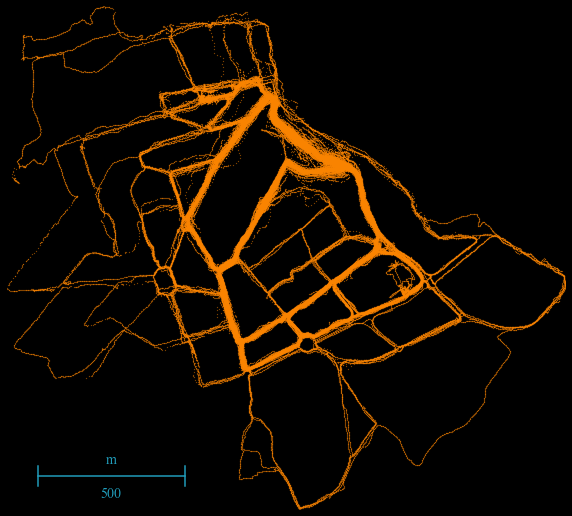

In [11]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
m.plot(lonall, latall, "o", ms=.2, color=mycolor1, latlon=True)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
m.drawmapscale(lonall.min() + .005, latall.min() + .001, lonall.min(), latall.min(), 500, 
               units="m",
               fontsize = 14, fontcolor=mycolor2)
plt.savefig(os.path.join(figdir, "sleeping02.jpg"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

In [12]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
m.plot(lonall, latall, "o", ms=.2, color=mycolor1, latlon=True)
m.plot(lonmean, latmean, "ro", latlon=True)
m.plot(lonmean.mean(), latmean.mean(), 'yo', ms=10, latlon=True)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
m.drawmapscale(lonall.min() + .005, latall.min() + .001, lonall.min(), latall.min(), 500, 
               units="m",
               fontsize = 14, fontcolor=mycolor2)
plt.savefig(os.path.join(figdir, "sleeping03.jpg"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

## 3. Altitude

In [13]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
scat = m.scatter(lonall, latall, s=1, c=eleall, 
                 cmap=plt.cm.viridis, latlon=True,
                 vmin=150., vmax=250.)
cb = plt.colorbar(scat, shrink=.7, extend="both")
for l in cb.ax.yaxis.get_ticklabels():
    l.set_fontsize(16)
    l.set_font_properties(myfont)
# cb.ax.tick_params(fontproperties=myfont)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig(os.path.join(figdir, "sleeping04.jpg"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

## 3b. Speed

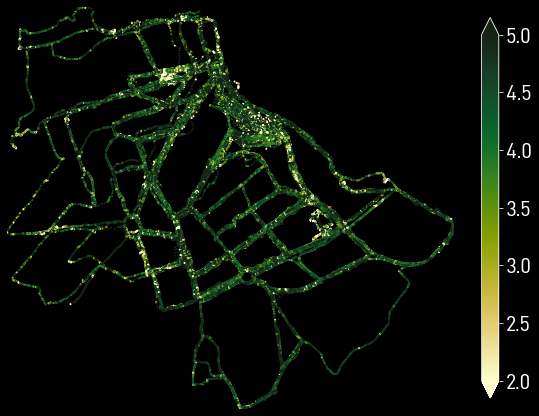

In [14]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
scat = m.scatter(lonall, latall, s=1, c=speedall, 
                 cmap=cmocean.cm.speed, latlon=True,
                 vmin=2., vmax=5.)
cb = plt.colorbar(scat, shrink=.7, extend="both")
for l in cb.ax.yaxis.get_ticklabels():
    l.set_fontsize(16)
    l.set_font_properties(myfont)
# cb.ax.tick_params(fontproperties=myfont)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig(os.path.join(figdir, "sleeping05.jpg"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

## 4. Hexbin

In [15]:
llon, llat = m(lonall, latall)

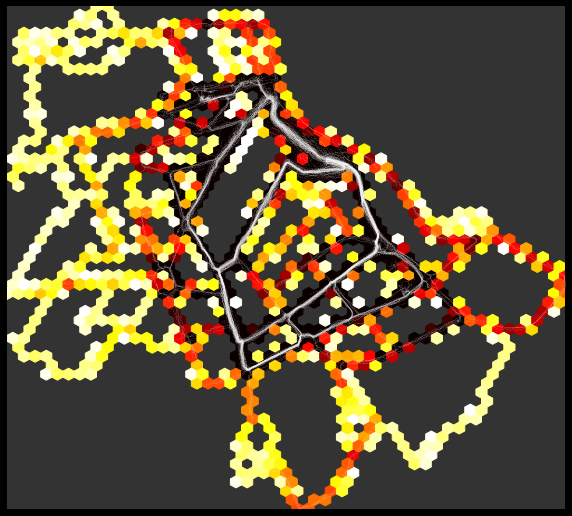

In [16]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
ax.set_facecolor('.2')
m.hexbin(llon, llat, cmap=plt.cm.hot_r, vmax=100, mincnt=2, gridsize=50, 
         reduce_C_function=np.log, zorder=3)

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig(os.path.join(figdir, "sleeping06.jpg"), dpi=300, bbox_inches="tight")
m.plot(lonall, latall, "o", ms=.1, color="w", latlon=True, alpha=.25, zorder=4)

plt.savefig(os.path.join(figdir, "sleeping07.jpg"), dpi=300, bbox_inches="tight")

plt.show()
plt.close()

In [17]:
import cartopy
import cartopy.crs as ccrs
import contextily as ctx
import configparser
import hikinggc

config = configparser.ConfigParser()
config.read("/etc/config.txt")
apikey = config.get("configuration", "thunderkey")
basemap = ctx.providers.Thunderforest.OpenCycleMap
basemap = ctx.providers.CartoDB["DarkMatterNoLabels"]
basemap["url"] = "https://{s}.tile.thunderforest.com/outdoors/{z}/{x}/{y}.png?apikey=%s" %(apikey)
proj = ccrs.epsg(3857)
basemap

ModuleNotFoundError: No module named 'cartopy'

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=proj)

for iii, datafile in enumerate(datafilelist):
    lon, lat, ele, t = GPX_functions.read_gpx(datafile)
    try:
        t0 = t[0]
        
        if t0.hour >= 17.:
            dist = GPX_functions.compute_dist(lon, lat)
            if dist.sum() < 6.:
                track = hikinggc.Track()
                track.get_coords(datafile)
                track.add_track(ax, color=mycolor1)
    except IndexError:
        logger.warning("No records in file {}".format(datafile))

if basemap is not None:
    ctx.add_basemap(ax, source=basemap, origin='upper')

# Add map scale
#hikinggc.scale_bar(ax, location=(0.15, 0.05), length=1)

ax.set_xticks([])
ax.set_yticks([])

plt.savefig(os.path.join(figdir, "sleeping08.jpg"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

In [ ]:
track0 = hikinggc.Track()
track0.lon = lonall
track0.lat = latall

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=proj)

track0.add_track(ax, color=mycolor1)
if basemap is not None:
    ctx.add_basemap(ax, source=basemap, origin='upper', z)


ax.set_xticks([])
ax.set_yticks([])

plt.savefig(os.path.join(figdir, "sleeping09.jpg"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()